github.com/harrisonjansma/Analyzing_Medium
kaggle.com/dskswu/topic-modeling-bert-lda
towardsdatascience.com/a-graph-of-medium-tags-8e3cf6cad1d9
spacy.io
radimrehurek.com/gensim


In [1]:
import os
from bs4 import BeautifulSoup
import json
import re
import requests
from python_graphql_client import GraphqlClient
import time
import pandas as pd
import datetime
import re
import numpy as np
from collections import Counter
from multiprocessing import Pool
from calendar import monthrange
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

In [2]:
popular_tags = ["technology", "startup", "data-science", "artificial-intelligence", "programming"]

In [3]:
filename = "scrapped_data.pkl"

In [4]:
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')  # Last I checked this was necessary.

In [5]:
def scrap_archive(soup):
    authors = []
    publications = []
    titles = []
    read_times = []
    claps = []
    dates = []
    links = []

    article_cards = soup.find_all('div',{'class': 'postArticle'})

    for card in article_cards:
        # Authors
        try:
            _author = card.select('a.ds-link')[0].text
        except:
            _author = None

        # Publications
        published_by_soup = card.select('a.ds-link')

        if len(published_by_soup) < 2:
            _publication = None
        else:
            _publication = published_by_soup[1].text

        # Links
        try:
            _link = card.find('div', {'class': 'postArticle-content'}).parent['href']
        except:
            _link = None

        # Titles
        title_soup = card.find('h3')

        if title_soup is None:
            title_soup = card.find('h4')

            if title_soup is not None:
                _title = title_soup.text
            else:
                _title = None
        else:
            _title = title_soup.text

        # Read times
        read_time_soup = card.find('span', {'class': 'readingTime'})
        if read_time_soup is not None:
            _read_time = int(read_time_soup['title'].replace(" min read",""))
        else:
            _read_time = None

        # Claps
        clap_soup = card.find('button',{'data-action':'show-recommends'})

        # no claps
        if clap_soup is None:
            _clap = 0
        # >1k claps
        elif 'K' in clap_soup.text:
            _clap = int(float(clap_soup.text.replace('K',''))*1000)
        # normal case
        else:
            _clap = int(clap_soup.text)

        # Dates
        try:
            _date = datetime.datetime.strptime(card.find('time')['datetime'], '%Y-%m-%dT%H:%M:%S.%f%z')
        except:
            _date = None

        if _author is not None and\
                _publication is not None and\
                _title is not None and\
                _read_time is not None and\
                _clap is not None and\
                _date is not None and\
                _link is not None:
            authors.append(_author)
            publications.append(_publication)
            titles.append(_title)
            read_times.append(_read_time)
            claps.append(_clap)
            dates.append(_date)
            links.append(_link)

    titles = [x.replace('\xa0',' ').replace('\u200a—\u200a','--').replace('--', ' — ') for x in titles]              


    archive_data = {
        'author': authors,
        'publication': publications,
        'title': titles,
        'read_time': read_times,
        'num_clap': claps,
        'date': dates,
        'url': links
    }

    return archive_data

In [6]:
def scrap_article(soup):
    try:
        tags = []
        tags = [x.text for x in soup.find_all("a", href=re.compile("^/tag\w*/(.*)"))]
        return tags
    except:
        print("Couldn't get article tags.")

In [7]:
def get_tags(row):
    if row.tag is not None:
        return row.tag
    time.sleep(np.random.randint(5) + 1)
    try:
        r = requests.get(row.url)
    except:
        return None
    s = BeautifulSoup(r.content)
    return scrap_article(s)

In [8]:
def scrap_tags(df, mp=True):
    if mp:
        pool = Pool(16)
        df['tag'] = pool.map(get_tags, df)
        pool.close()
        pool.join()
    else:
        df['tag'] = df.apply(get_tags)

In [9]:
def scrap(tag, day, month, year, nb_iter=0, mp_tags=True):
    df = None
    try:
        url = f"https://medium.com/tag/{tag}/archive/{year}/{month}/{day}"
        driver = webdriver.Chrome(options=options)
        driver.get(url)
        soup = BeautifulSoup(driver.page_source)
        try:
            data = scrap_archive(soup)
        except:            
            raise
        df = pd.DataFrame(data)
        scrap_tags(df, mp=mp_tags)
    except ConnectionError:
        time.sleep(300)
        return scrap(tag, day, month, year, 0)
    except:
        if nb_iter < 2:
            time.sleep(np.random.randint(5) + 1)
            return scrap(tag, day, month, year, nb_iter + 1)
        else:
            print(f"An error occured during processing of {url}")
            raise
            return None
    
    return df

# Scrap

In [10]:
def get_data(scrap=True):
    if scrap:
        now = datetime.datetime.now()
        data = []
        fails = []

        for tag in popular_tags:
            for m in range(now.month):
                month = f"{m + 1:02d}"
                for d in range(monthrange(2020, m + 1)[1]):
                    day = f"{d + 1:02d}"
                    if datetime.datetime(2020, m + 1, d + 1) <= datetime.datetime(now.year, now.month, now.day):
                        scrapped_data = scrap(tag, day, month, 2020)                
                        if scrapped_data is not None:
                            if os.path.exists(filename):
                                df = pd.concat([pd.read_pickle(filename), scrapped_data], ignore_index=True)
                            else:
                                scrapped_data.to_pickle(filename)
                            data.append(scrapped_data)
                        else:
                            fails.append({'day': day, 'month': month, 'tag':tag})
                        time.sleep(np.random.randint(5) + 1)

        df = pd.concat(data)
        df.to_pickle(filename)
    else:
        df = pd.read_pickle(filename)
        
    return df

In [11]:
df = get_data(scrap=False)

In [12]:
len(df)

52535

In [13]:
df.head()

,author,publication,title,read_time,num_clap,date,url,tag
0,Eden Au,Towards Data Science,6 New Features in Python 3.8 for Python Newbies,4,1700,2020-01-01 23:27:59.289000+00:00,https://towardsdatascience.com/6-new-features-...,"[Programming, Technology, Coding, Python, Data]"
1,John Au-Yeung,JavaScript In Plain English,How to Use Input Masks to Validate Input in an...,6,123,2020-01-01 08:06:01.263000+00:00,https://medium.com/javascript-in-plain-english...,"[JavaScript, Programming, Software Development..."
2,Tim Ventura,The Startup,10 Giant Technology Trends For The 2020's,5,434,2020-01-01 08:16:26.158000+00:00,https://medium.com/swlh/10-giant-technology-tr...,"[Futurism, Technology, Society, Trends]"
3,J. Lund,The Startup,SpaceX Doubles Down From Starship Failure,3,606,2020-01-01 17:56:51.493000+00:00,https://medium.com/swlh/spacex-doubles-down-fr...,"[Elon Musk, Space, Spacex, Technology, Tech]"
4,Nino Ulsamer,StashAway Engineering,A review of 2019,9,133,2020-01-01 08:59:41.882000+00:00,https://medium.com/stashaway-engineering/a-rev...,"[Fintech, Product Development, Technology, Sta..."


## Remove duplicates

In [14]:
dfu = df.drop_duplicates(subset=["author", "publication", "title", "url"])

In [15]:
len(dfu[dfu.tag.isnull()])

47

In [16]:
len(dfu[dfu.tag.notnull()])

51952

In [17]:
len(dfu)

51999

In [18]:
def get_sorted_tags(df, weight=None):
    tags = []
    if weight is not None:
        for r,n in zip(df.tag, df[weight]):
            tags.extend(r * n)
    else:
        for r in df.tag:
            tags.extend(r)
    c = Counter(tags)
    return c

In [19]:
get_sorted_tags(dfu[dfu.tag.notnull()]).most_common(20)

[('Technology', 18437),
 ('Programming', 16475),
 ('Data Science', 14426),
 ('Startup', 12034),
 ('Artificial Intelligence', 10111),
 ('Machine Learning', 9567),
 ('JavaScript', 5060),
 ('Software Development', 4890),
 ('Python', 4842),
 ('Business', 3855),
 ('Web Development', 3762),
 ('Entrepreneurship', 2898),
 ('AI', 1952),
 ('Deep Learning', 1936),
 ('Tech', 1900),
 ('Software Engineering', 1846),
 ('Coding', 1839),
 ('Covid 19', 1603),
 ('Data', 1488),
 ('Venture Capital', 1484)]

In [20]:
get_sorted_tags(dfu[dfu.tag.notnull()], "num_clap").most_common(20)

[('Programming', 3332558),
 ('Technology', 3104940),
 ('Data Science', 2147259),
 ('Startup', 1921511),
 ('Machine Learning', 1349187),
 ('Artificial Intelligence', 1324018),
 ('JavaScript', 1245986),
 ('Software Development', 1128758),
 ('Python', 920902),
 ('Web Development', 832483),
 ('Business', 745931),
 ('Entrepreneurship', 701904),
 ('Software Engineering', 417482),
 ('Productivity', 400626),
 ('Coding', 338596),
 ('React', 309083),
 ('Tech', 294493),
 ('Deep Learning', 283913),
 ('Writing', 257909),
 ('Work', 250232)]

## Read Time vs claps

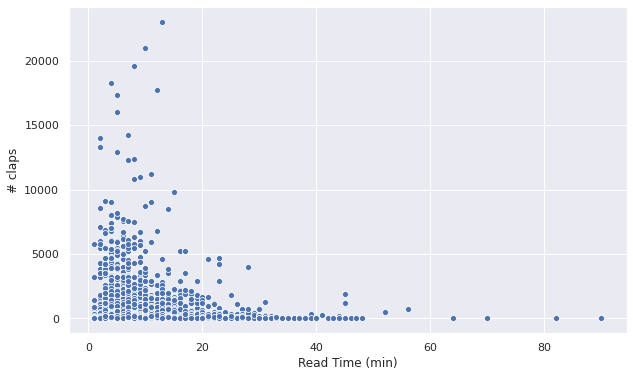

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
ddfu = dfu[(dfu.num_clap>0) & (dfu.read_time>0) & dfu.num_clap.notnull() & dfu.read_time.notnull()].sort_values(by=['read_time'])
sns.scatterplot(x="read_time", y="num_clap", data=ddfu).set(xlabel='Read Time (min)', ylabel='# claps');

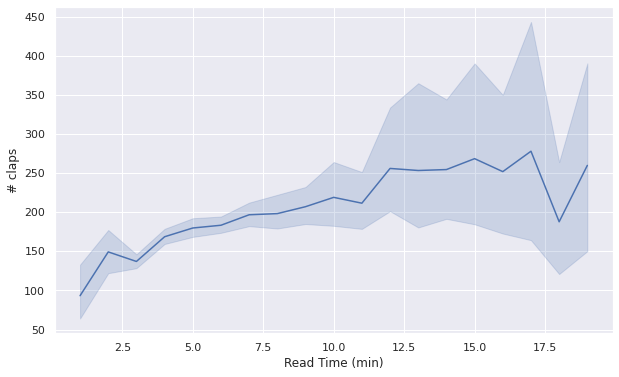

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x="read_time", y="num_clap", data=ddfu[ddfu.read_time < 20]).set(xlabel='Read Time (min)', ylabel='# claps');

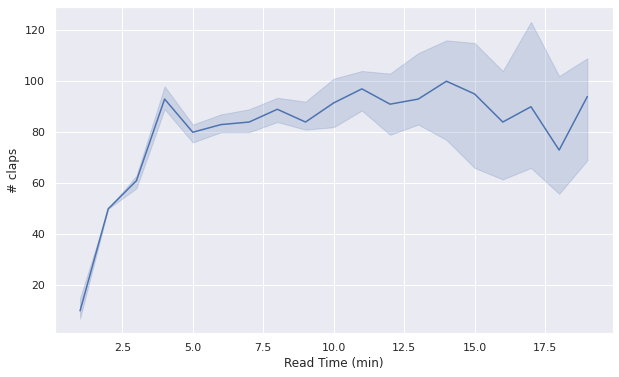

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x="read_time", y="num_clap", data=ddfu[ddfu.read_time < 20], estimator=np.median).set(xlabel='Read Time (min)', ylabel='# claps');

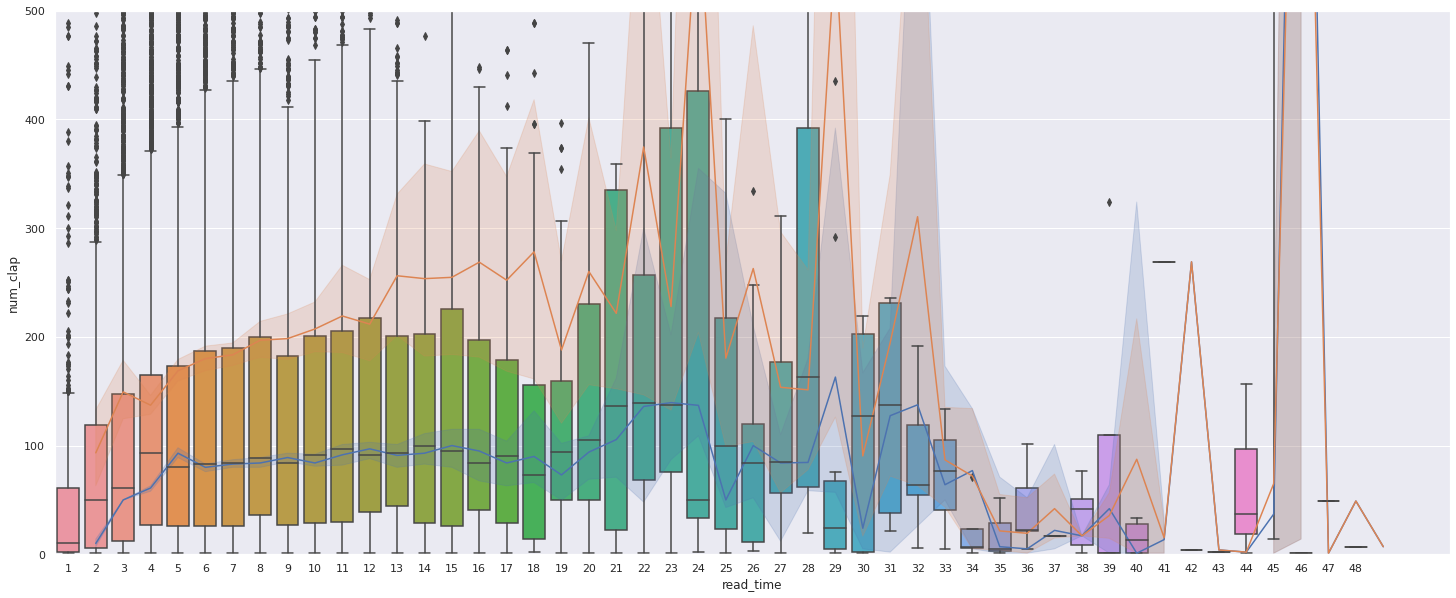

In [24]:
fig, ax = plt.subplots(figsize=(25,10))
sns.boxplot(x="read_time", y="num_clap", data=ddfu[ddfu.read_time < 50], ax=ax).set(ylim=(0, 500), xlabel='Read Time (min)', ylabel='# claps');
sns.lineplot(x="read_time", y="num_clap", data=ddfu[ddfu.read_time < 50], estimator=np.median);
sns.lineplot(x="read_time", y="num_clap", data=ddfu[ddfu.read_time < 50]);

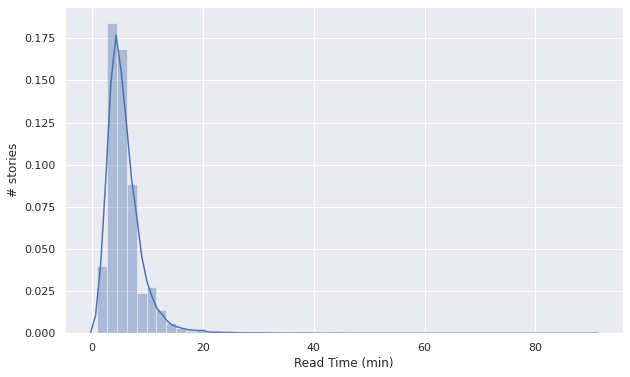

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(ddfu.read_time, bins=50).set(xlabel='Read Time (min)', ylabel='# stories');

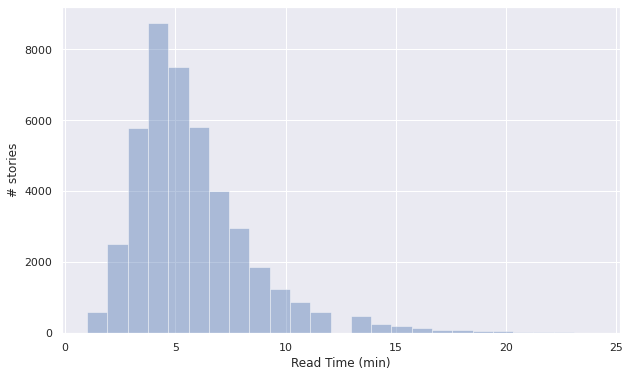

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(ddfu[ddfu.read_time<25].read_time, kde=False, bins=25).set(xlabel='Read Time (min)', ylabel='# stories');

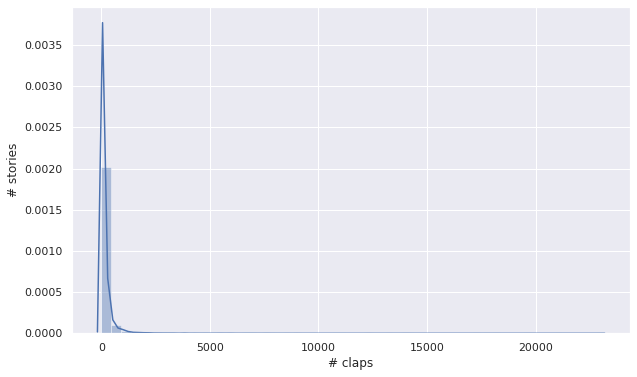

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(ddfu.num_clap, bins=50).set(xlabel='# claps', ylabel='# stories');

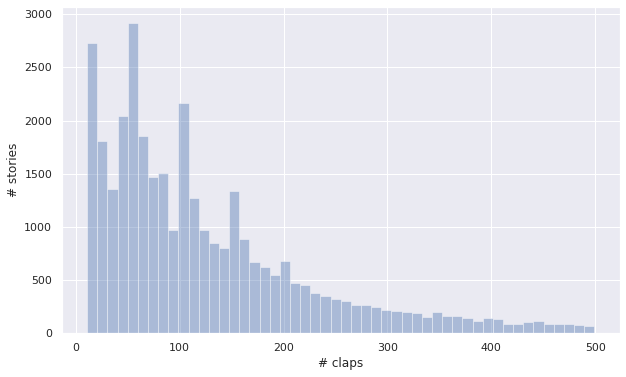

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(ddfu[(ddfu.num_clap<500)&(ddfu.num_clap>10)].num_clap, kde=False, bins=50).set(xlabel='# claps', ylabel='# stories');

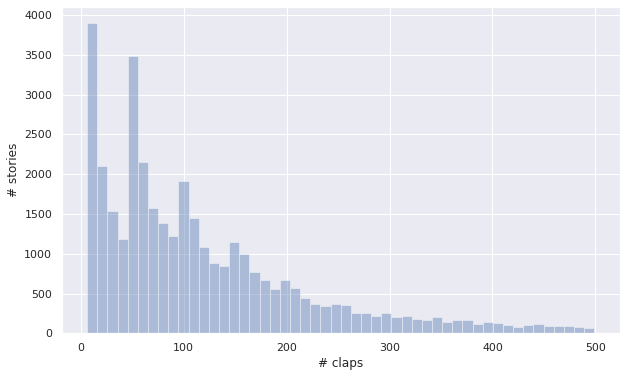

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(ddfu[(ddfu.num_clap<500)&(ddfu.num_clap>5)].num_clap, kde=False, bins=50).set(xlabel='# claps', ylabel='# stories');

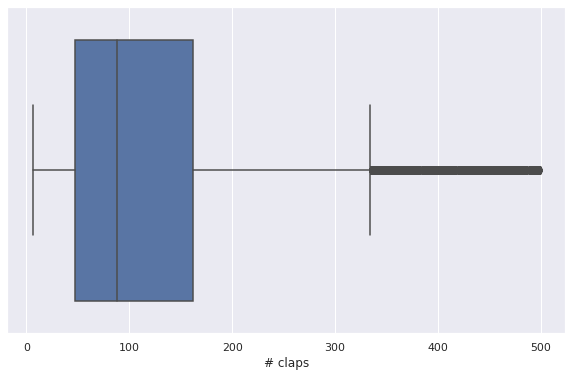

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x="num_clap", data=ddfu[(ddfu.num_clap<500)&(ddfu.num_clap>5)]).set(xlabel="# claps");

In [31]:
ddfu[(ddfu.num_clap<500)&(ddfu.num_clap>5)].num_clap.mean()

118.01913956164229

On peut se demander maintenant 
* C'est quoi le genre d'articles qui prennentplus de 25-30 minuts a lire
* C'est quoi le genre d'article qui recolte des claps astronomiques

## Large clap numbers

In [32]:
len(ddfu[ddfu.num_clap>1000])

956

In [33]:
get_sorted_tags(ddfu[ddfu.num_clap>10000]).most_common(10)

[('Startup', 9),
 ('Technology', 7),
 ('Programming', 6),
 ('Productivity', 5),
 ('Entrepreneurship', 4),
 ('Creativity', 3),
 ('Blockchain', 2),
 ('Incubation', 2),
 ('Partnerships', 2),
 ('JavaScript', 2)]

In [34]:
get_sorted_tags(ddfu[ddfu.num_clap>1000]).most_common(10)

[('Programming', 388),
 ('Technology', 357),
 ('Startup', 289),
 ('Data Science', 220),
 ('JavaScript', 154),
 ('Entrepreneurship', 148),
 ('Software Development', 144),
 ('Python', 124),
 ('Artificial Intelligence', 120),
 ('Machine Learning', 119)]

## Nb articles per author

In [35]:
ddfu.author.value_counts()

John Au-Yeung            2056
Synced                    373
Faisal Khan               173
Yong Cui, Ph.D.           171
Sadrach Pierre, Ph.D.     160
                         ... 
Alessio Simoya              1
Stan Fedorov                1
Nicolas Vieira              1
Filip Haftek                1
Fausto Milletari            1
Name: author, Length: 15212, dtype: int64

In [36]:
count_author = ddfu.groupby(by=['author'])['author'].count()
count_author.mean()

2.912306074151985

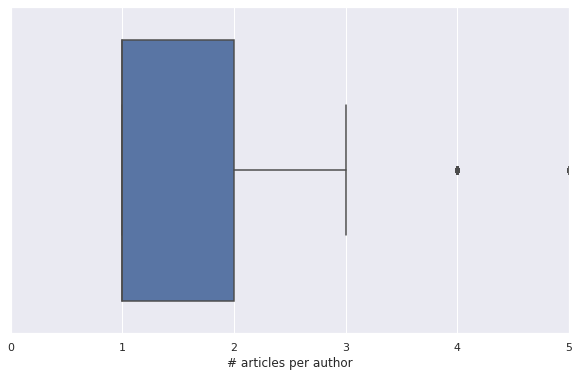

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(count_author).set(xlim=(0, 5), xlabel='# articles per author');

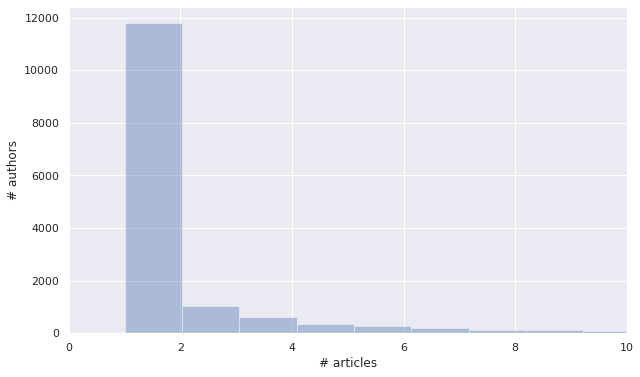

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(count_author, kde=False, bins=2000).set(xlim=(0, 10), xlabel='# articles', ylabel='# authors');

In [39]:
# Number of published articles for high clap authors
best_authors = ddfu[ddfu.num_clap > 100].author.unique()
best_count_author = count_author[best_authors]
best_count_author.mean()

4.599484037407288

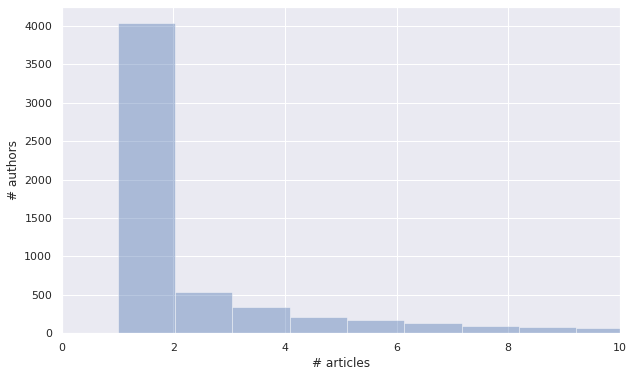

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(best_count_author, kde=False, bins=2000).set(xlim=(0, 10), xlabel='# articles', ylabel='# authors');

In [41]:
# Number of best authors that published only one article vs others
nb_best_authors = len(best_authors)
nb_best_authors_one_article = sum(best_count_author==1)
nb_best_authors_more_article = sum(best_count_author>1)
print("Number of best authors that published only one article vs others")
print(f"Total {nb_best_authors} best authors")
print("")
print(f"Only one story:      {nb_best_authors_one_article}({nb_best_authors_one_article/nb_best_authors:1.0%})")
print("                vs")
print(f"More than one story: {nb_best_authors_more_article}({nb_best_authors_more_article/nb_best_authors:1.0%})")

Number of best authors that published only one article vs others
Total 6202 best authors

Only one story:      2884(47%)
                vs
More than one story: 3318(53%)


## Long long long stories: Will be in an article using NLP

In [42]:
long_stories = ddfu[ddfu.read_time>25]

In [43]:
get_sorted_tags(long_stories).most_common(10)

[('Technology', 63),
 ('Data Science', 33),
 ('Startup', 33),
 ('Artificial Intelligence', 24),
 ('Machine Learning', 20),
 ('Programming', 18),
 ('Software Development', 17),
 ('Management', 15),
 ('Computer Science', 13),
 ('Leadership', 13)]